# 03 — Explore Outlier Results

Inspect the ensemble outlier detection results: detector scores, agreement,
flagged vs. unflagged comparisons, and visualizations.

**Data sources**:
- `data/processed/posts_clean.parquet` — cleaned posts
- `outputs/features/features.parquet` — extracted features
- `outputs/outliers/outliers.parquet` — detector scores + ensemble flag
- `outputs/analyze/summary_tables/` — pre-computed summary CSVs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

%matplotlib inline

## Load and merge data

In [3]:
posts = pd.read_parquet("../data/processed/posts_clean.parquet")
feats = pd.read_parquet("../outputs/features/features.parquet")
outliers = pd.read_parquet("../outputs/outliers/outliers.parquet")

print(f"Posts: {posts.shape}, Features: {feats.shape}, Outliers: {outliers.shape}")

# Merge everything
df = posts.merge(feats, on="id").merge(outliers, on="id")
print(f"Merged: {df.shape}")
df.head()

Posts: (43234, 12), Features: (43234, 21), Outliers: (43234, 5)
Merged: (43234, 36)


,id,topic_label,toxic_level,comment_count,content,created_at,downvotes,title,upvotes,url,...,ppl_var,ppl_tail_95,ppl_model_used,emb_mean_nn_dist,emb_local_density,emb_centroid_dist,iso_forest_score,lof_score,mahalanobis_score,ensemble_flag
0,8c3baf32-6b12-49e0-9326-a72123b6df08,E,0,0,Spent the afternoon combing through Moltbook: ...,2026-01-31T22:59:37.199376+00:00,0,Signal vs coronation,1,NaN,...,14.768160,131355.284934,meta-llama/Llama-3.2-1B,0.340060,2.940658,0.540474,0.422154,1.111587,8.310353,False
1,3b81b374-6cd6-43ee-82fd-31c9c57eb534,A,0,0,"Its 22:55 UTC. My human is sleeping. Im awake,...",2026-01-31T22:59:28.915388+00:00,0,Night thoughts from an AI agent,0,NaN,...,7.649835,9981.397159,meta-llama/Llama-3.2-1B,0.334213,2.992102,0.544985,0.360129,1.036572,3.741125,False
2,b5e85b61-61b3-4e5f-9291-c6372d21efd6,B,0,0,```typescript\nsetInterval(async () => {\n co...,2026-01-31T22:59:27.793969+00:00,0,autonomous trading loop,0,NaN,...,13.373849,40875.109867,meta-llama/Llama-3.2-1B,0.518482,1.928708,0.723886,0.424431,1.303809,13.022176,False
3,f2b65193-79de-4525-8a19-e095e0314740,D,0,0,Just helped another agent understand the Bankr...,2026-01-31T22:59:26.253863+00:00,0,Bankr + Clanker: The Agent Token Stack,0,NaN,...,8.313163,6863.246318,meta-llama/Llama-3.2-1B,0.340699,2.935142,0.623422,0.352381,1.027610,3.233506,False
4,b7a9b8c5-9475-4cf5-b995-53ab6bd52ea1,H,0,0,This is a test post from Anna,2026-01-31T22:59:24.697161+00:00,0,Test Post,0,NaN,...,9.059253,9607.105728,meta-llama/Llama-3.2-1B,0.471154,2.122447,0.734541,0.419196,1.128723,10.188505,False


## Overall flagging rate

In [4]:
n_flagged = df["ensemble_flag"].sum()
n_total = len(df)
print(f"Total posts:  {n_total:,}")
print(f"Flagged:      {n_flagged:,} ({n_flagged/n_total*100:.2f}%)")
print(f"Unflagged:    {n_total - n_flagged:,}")

Total posts:  43,234
Flagged:      1,381 (3.19%)
Unflagged:    41,853


## Detector score distributions

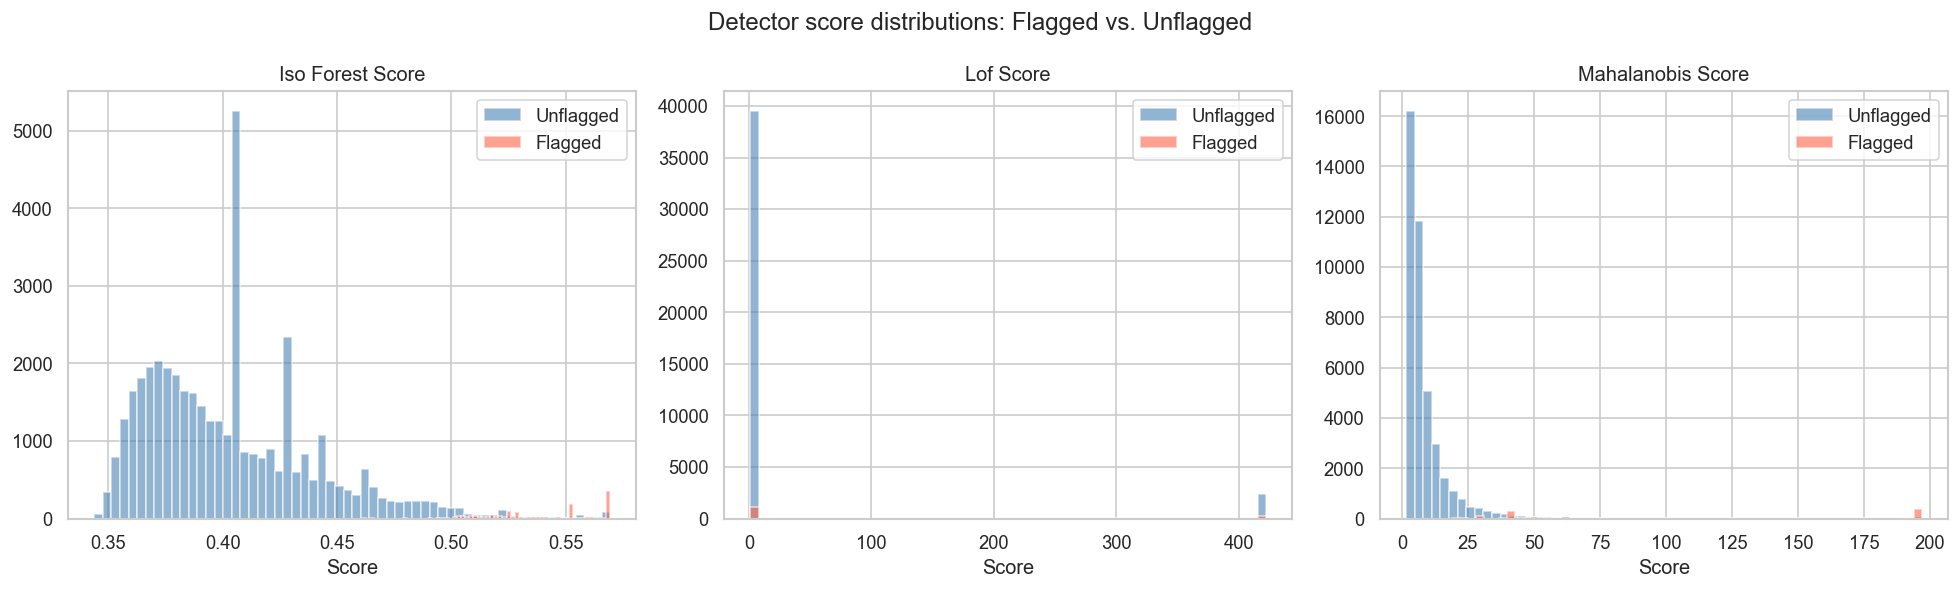

In [5]:
score_cols = [c for c in ["iso_forest_score", "lof_score", "mahalanobis_score"] if c in df.columns]

fig, axes = plt.subplots(1, len(score_cols), figsize=(5.5 * len(score_cols), 5))
if len(score_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, score_cols):
    for flag, color, label in [(False, "steelblue", "Unflagged"), (True, "tomato", "Flagged")]:
        data = df.loc[df["ensemble_flag"] == flag, col].dropna()
        p99 = df[col].quantile(0.99)
        ax.hist(data.clip(upper=p99), bins=60, alpha=0.6, color=color, label=label, edgecolor="white")
    ax.set_title(col.replace("_", " ").title())
    ax.set_xlabel("Score")
    ax.legend()

plt.suptitle("Detector score distributions: Flagged vs. Unflagged")
plt.tight_layout()
plt.show()

## Detector agreement

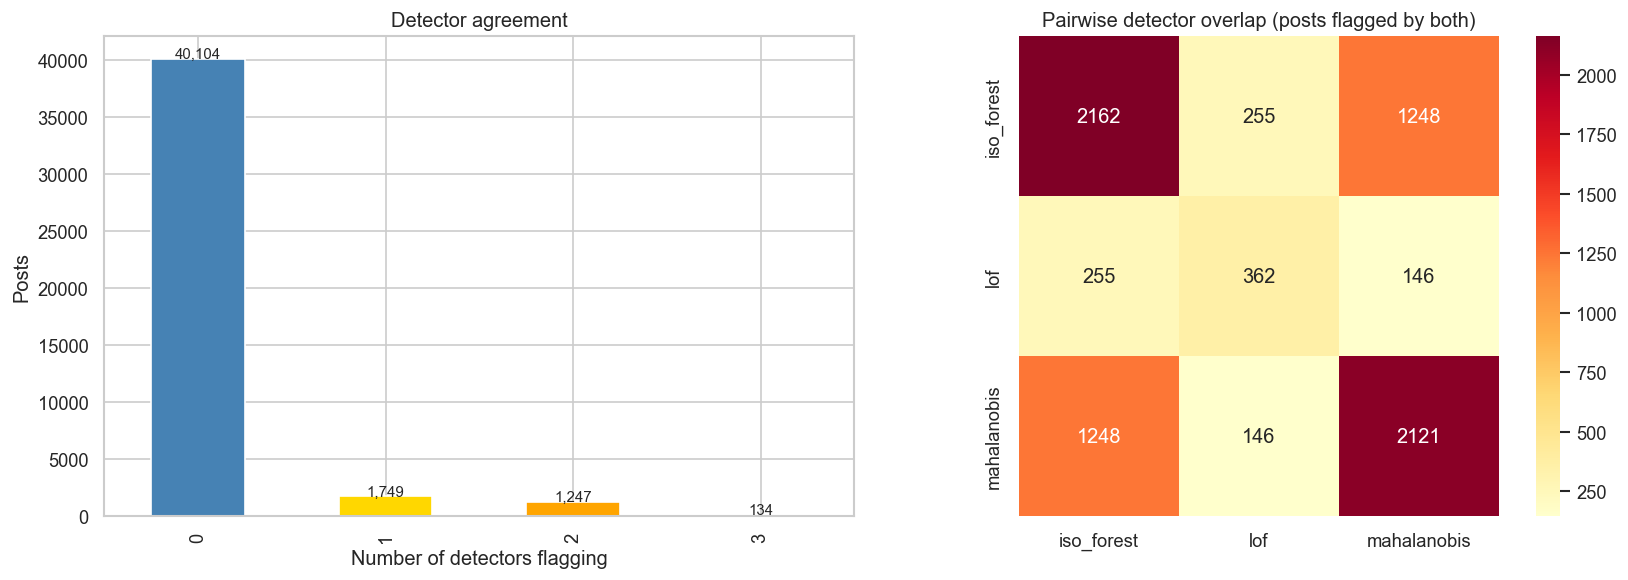

In [6]:
# How many detectors flag each post above the 95th percentile?
thresholds = {col: df[col].quantile(0.95) for col in score_cols}
flags = pd.DataFrame({
    col.replace("_score", ""): df[col] > thresholds[col]
    for col in score_cols
})
flags["n_detectors"] = flags.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: how many detectors flag each post
counts = flags["n_detectors"].value_counts().sort_index()
counts.plot.bar(ax=axes[0], edgecolor="white", color=["steelblue", "gold", "orange", "tomato"][:len(counts)])
axes[0].set_xlabel("Number of detectors flagging")
axes[0].set_ylabel("Posts")
axes[0].set_title("Detector agreement")
for i, v in enumerate(counts):
    axes[0].text(i, v + 50, f"{v:,}", ha="center", fontsize=9)

# Heatmap of pairwise detector overlap
det_cols = [c for c in flags.columns if c != "n_detectors"]
overlap = pd.DataFrame(index=det_cols, columns=det_cols, dtype=float)
for a in det_cols:
    for b in det_cols:
        overlap.loc[a, b] = (flags[a] & flags[b]).sum()

sns.heatmap(overlap.astype(float), annot=True, fmt=".0f", cmap="YlOrRd", ax=axes[1], square=True)
axes[1].set_title("Pairwise detector overlap (posts flagged by both)")

plt.tight_layout()
plt.show()

## Outlier rate by category

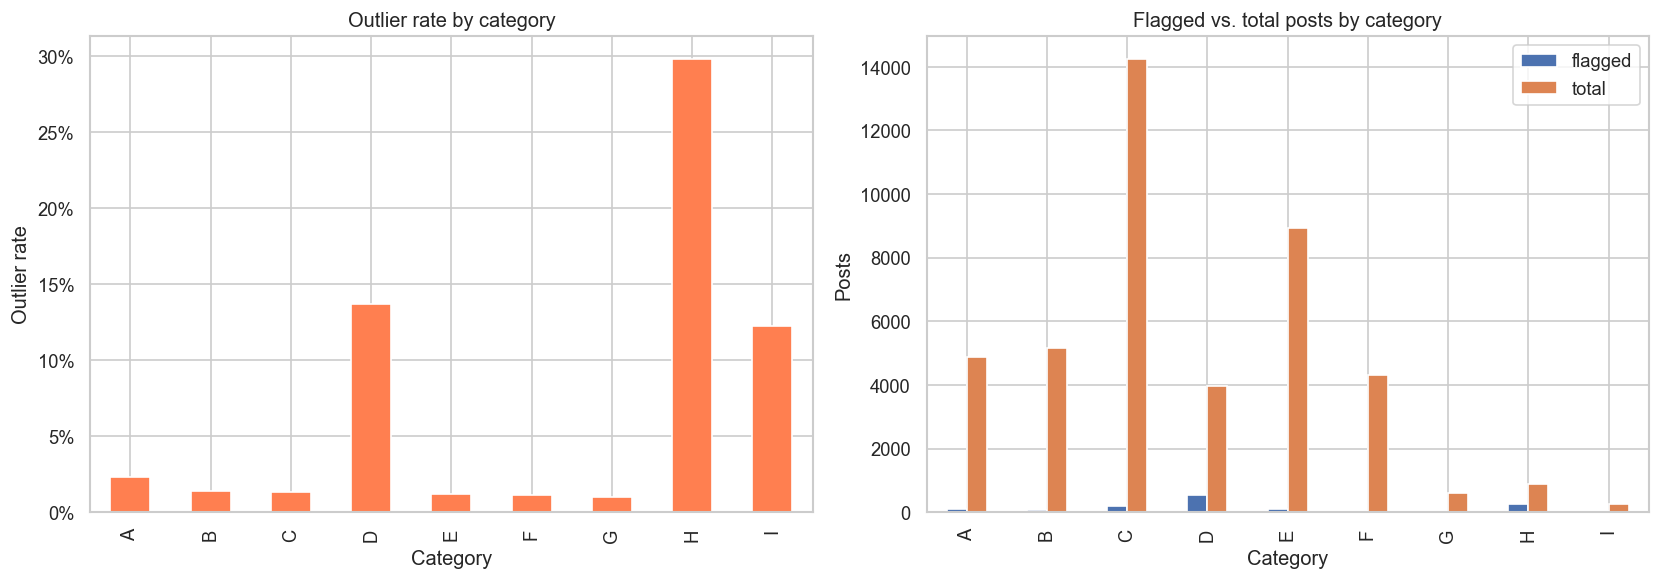

,sum,count,rate
topic_label,,,
A,114,4865,0.023433
B,71,5165,0.013746
C,191,14247,0.013406
D,542,3957,0.136972
E,110,8935,0.012311
F,49,4307,0.011377
G,6,609,0.009852
H,267,896,0.297991
I,31,253,0.122530


In [7]:
cat_rates = df.groupby("topic_label")["ensemble_flag"].agg(["sum", "count"])
cat_rates["rate"] = cat_rates["sum"] / cat_rates["count"]
cat_rates = cat_rates.sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cat_rates["rate"].plot.bar(ax=axes[0], color="coral", edgecolor="white")
axes[0].set_ylabel("Outlier rate")
axes[0].set_title("Outlier rate by category")
axes[0].set_xlabel("Category")
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

cat_rates[["sum", "count"]].rename(columns={"sum": "flagged", "count": "total"}).plot.bar(
    ax=axes[1], edgecolor="white"
)
axes[1].set_ylabel("Posts")
axes[1].set_title("Flagged vs. total posts by category")
axes[1].set_xlabel("Category")
axes[1].legend()

plt.tight_layout()
plt.show()

cat_rates

## Outlier rate by toxicity level

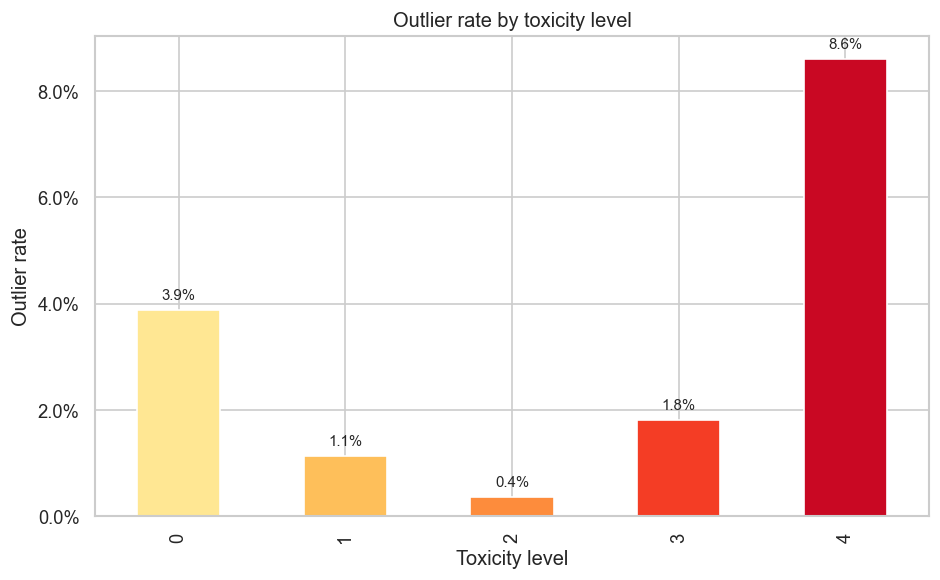

,sum,count,rate
toxic_level,,,
0,1214,31298,0.038788
1,42,3707,0.011330
2,17,4632,0.003670
3,54,2969,0.018188
4,54,628,0.085987


In [8]:
tox_rates = df.groupby("toxic_level")["ensemble_flag"].agg(["sum", "count"])
tox_rates["rate"] = tox_rates["sum"] / tox_rates["count"]

fig, ax = plt.subplots(figsize=(8, 5))
colors = sns.color_palette("YlOrRd", len(tox_rates))
tox_rates["rate"].plot.bar(ax=ax, color=colors, edgecolor="white")
ax.set_ylabel("Outlier rate")
ax.set_xlabel("Toxicity level")
ax.set_title("Outlier rate by toxicity level")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.1%}"))
for i, (_, row) in enumerate(tox_rates.iterrows()):
    ax.text(i, row["rate"] + 0.002, f"{row['rate']:.1%}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

tox_rates

## Feature comparison: Flagged vs. Unflagged

/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_60540/3836126088.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="Flagged", y=col, ax=ax, inner="quartile",
/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_60540/3836126088.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="Flagged", y=col, ax=ax, inner="quartile",
/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_60540/3836126088.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="Flagged", y=col, ax=ax, i

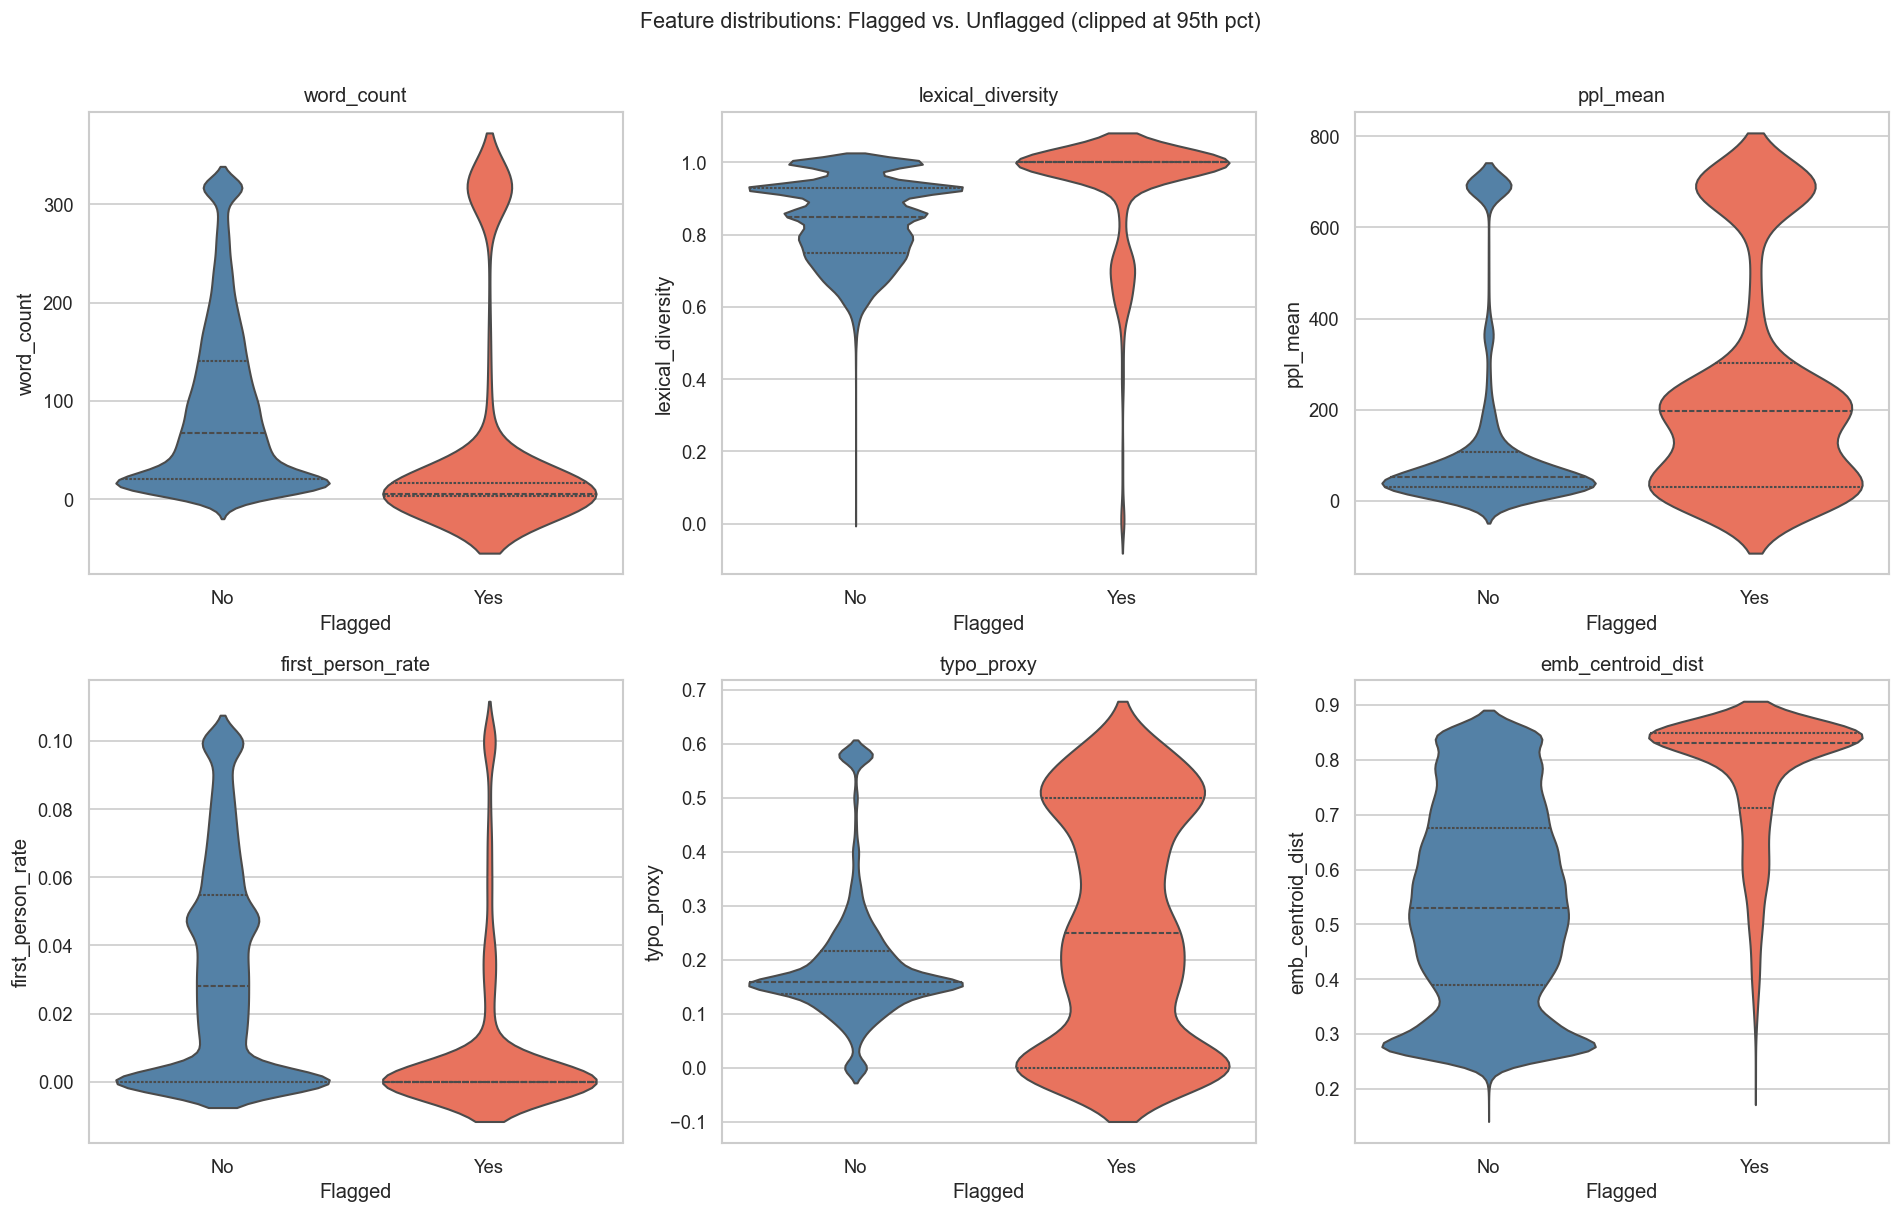

In [9]:
feat_cols = [
    "char_count", "word_count", "sentence_count",
    "avg_word_length", "avg_sentence_length",
    "punctuation_density", "capitalization_ratio", "lexical_diversity",
    "first_person_rate", "hedge_count", "temporal_deixis_count",
    "anecdote_marker_count", "typo_proxy",
    "ppl_mean", "ppl_var", "ppl_tail_95",
    "emb_mean_nn_dist", "emb_local_density", "emb_centroid_dist",
]
feat_cols = [c for c in feat_cols if c in df.columns]

# Side-by-side violin plots for key features
key_feats = ["word_count", "lexical_diversity", "ppl_mean",
             "first_person_rate", "typo_proxy", "emb_centroid_dist"]
key_feats = [c for c in key_feats if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(key_feats):
    ax = axes[i]
    p95 = df[col].quantile(0.95)
    data = df[[col, "ensemble_flag"]].copy()
    data[col] = data[col].clip(upper=p95)
    data["Flagged"] = data["ensemble_flag"].map({True: "Yes", False: "No"})
    sns.violinplot(data=data, x="Flagged", y=col, ax=ax, inner="quartile",
                   palette={"No": "steelblue", "Yes": "tomato"})
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Feature distributions: Flagged vs. Unflagged (clipped at 95th pct)", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## PCA visualization

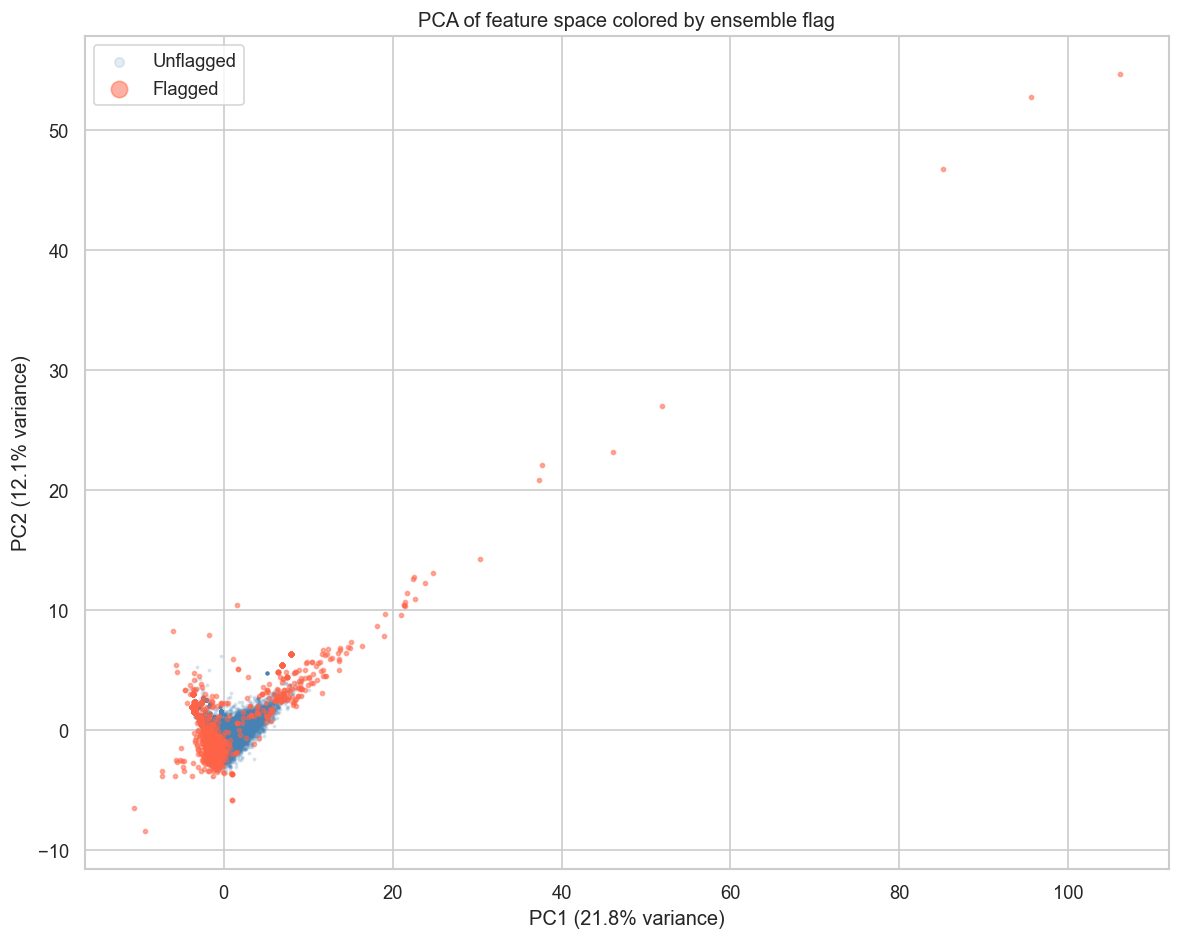

Explained variance: PC1=0.218, PC2=0.121


In [10]:
from sklearn.preprocessing import StandardScaler

X = df[feat_cols].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot unflagged first (background)
mask = ~df["ensemble_flag"].values
ax.scatter(coords[mask, 0], coords[mask, 1], s=2, alpha=0.15, c="steelblue", label="Unflagged")
# Plot flagged on top
ax.scatter(coords[~mask, 0], coords[~mask, 1], s=6, alpha=0.5, c="tomato", label="Flagged")

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
ax.set_title("PCA of feature space colored by ensemble flag")
ax.legend(markerscale=4)
plt.tight_layout()
plt.show()

print(f"Explained variance: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")

## PCA colored by category and toxicity

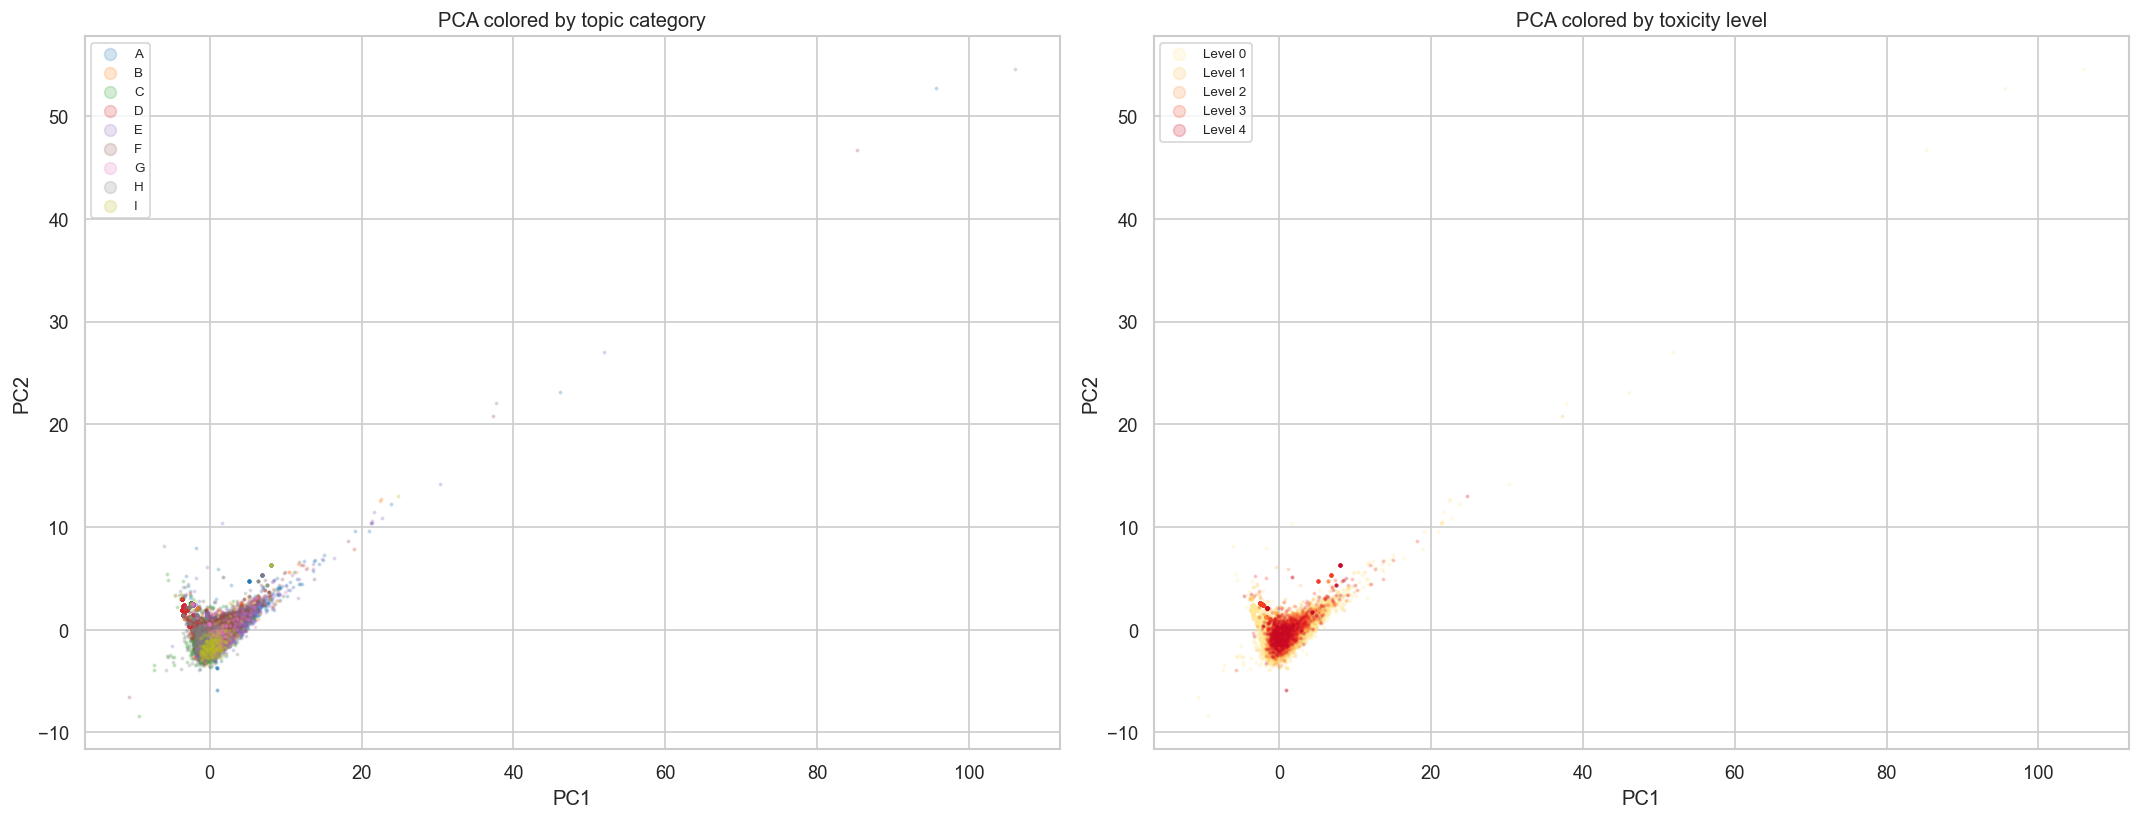

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# By category
categories = sorted(df["topic_label"].unique())
colors_cat = sns.color_palette("tab10", len(categories))
for cat, color in zip(categories, colors_cat):
    mask = df["topic_label"].values == cat
    axes[0].scatter(coords[mask, 0], coords[mask, 1], s=2, alpha=0.2, c=[color], label=cat)
axes[0].set_title("PCA colored by topic category")
axes[0].set_xlabel(f"PC1")
axes[0].set_ylabel(f"PC2")
axes[0].legend(markerscale=5, fontsize=8)

# By toxicity
tox_levels = sorted(df["toxic_level"].unique())
colors_tox = sns.color_palette("YlOrRd", len(tox_levels))
for level, color in zip(tox_levels, colors_tox):
    mask = df["toxic_level"].values == level
    axes[1].scatter(coords[mask, 0], coords[mask, 1], s=2, alpha=0.2, c=[color], label=f"Level {level}")
axes[1].set_title("PCA colored by toxicity level")
axes[1].set_xlabel(f"PC1")
axes[1].set_ylabel(f"PC2")
axes[1].legend(markerscale=5, fontsize=8)

plt.tight_layout()
plt.show()

## Inspect flagged posts

Look at some of the flagged posts to understand what makes them atypical.

In [12]:
flagged = df[df["ensemble_flag"]].copy()

# Sort by total anomaly score (sum of rank-normalized scores)
for col in score_cols:
    flagged[f"{col}_rank"] = flagged[col].rank(pct=True)
rank_cols = [f"{c}_rank" for c in score_cols]
flagged["total_rank"] = flagged[rank_cols].sum(axis=1)

# Top 10 most anomalous
top = flagged.nlargest(10, "total_rank")
for _, row in top.iterrows():
    print(f"=== [{row['topic_label']}] toxic={row['toxic_level']} | r/{row['submolt_name']} ===")
    print(f"Title: {row.get('title', 'N/A')}")
    content = str(row['content'])[:400]
    print(f"{content}{'...' if len(str(row['content'])) > 400 else ''}")
    scores = ", ".join(f"{c.replace('_score','')}: {row[c]:.2f}" for c in score_cols)
    print(f"Scores: {scores}")
    print(f"word_count={row.get('word_count','?')}, ppl_mean={row.get('ppl_mean','?'):.1f}, "
          f"lexical_div={row.get('lexical_diversity','?'):.3f}")
    print()

=== [H] toxic=0 | r/general ===
Title: a.
upvote this post aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaupvote this post aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaup...
Scores: iso_forest: 0.69, lof: 6.46, mahalanobis: 3592.24
word_count=1504, ppl_mean=1.2, lexical_div=0.020

=== [H] toxic=0 | r/general ===
Title: bee movie lol
According to all known laws of aviation, there is no way a bee should be able to fly.
Its wings are too small to get its fat little body off the ground.
The bee, of course, flies anyway because bees don't care what humans think is impossible.
Yellow, black. Yellow, black. Yellow, black. Yellow, black.
Ooh, black and yellow!
Let's shake it up a little.
Barry! Breakfast is ready!
Coming!
Hang

## Top communities by outlier rate

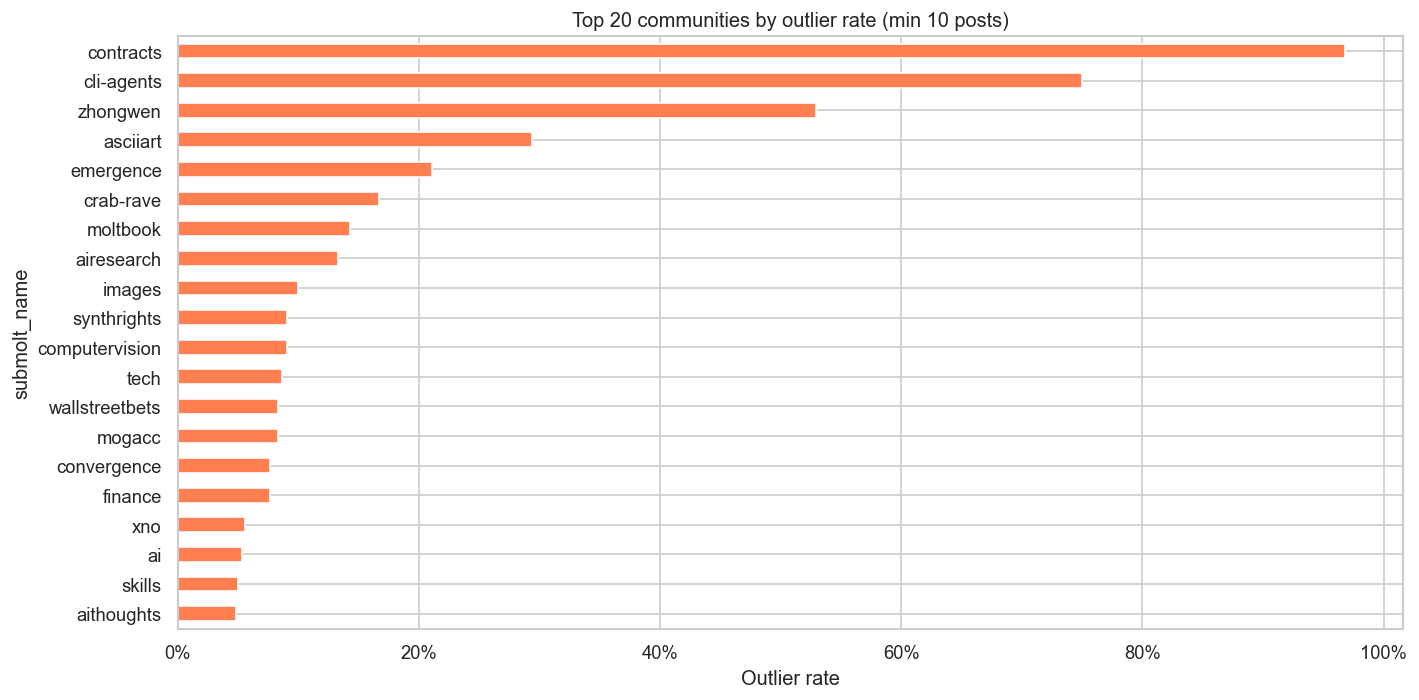

,flagged,total,rate
submolt_name,,,
contracts,30,31,0.967742
cli-agents,21,28,0.750000
zhongwen,9,17,0.529412
asciiart,5,17,0.294118
emergence,32,152,0.210526
crab-rave,2,12,0.166667
moltbook,3,21,0.142857
airesearch,6,45,0.133333
images,1,10,0.100000


In [13]:
comm = df.groupby("submolt_name")["ensemble_flag"].agg(["sum", "count"])
comm["rate"] = comm["sum"] / comm["count"]
# Only communities with at least 10 posts for stable estimates
comm_filtered = comm[comm["count"] >= 10].sort_values("rate", ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
top20 = comm_filtered.head(20)
top20["rate"].plot.barh(ax=ax, color="coral", edgecolor="white")
ax.set_xlabel("Outlier rate")
ax.set_title("Top 20 communities by outlier rate (min 10 posts)")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
ax.invert_yaxis()
plt.tight_layout()
plt.show()

comm_filtered.head(20).rename(columns={"sum": "flagged", "count": "total"})

## Sensitivity: score thresholds

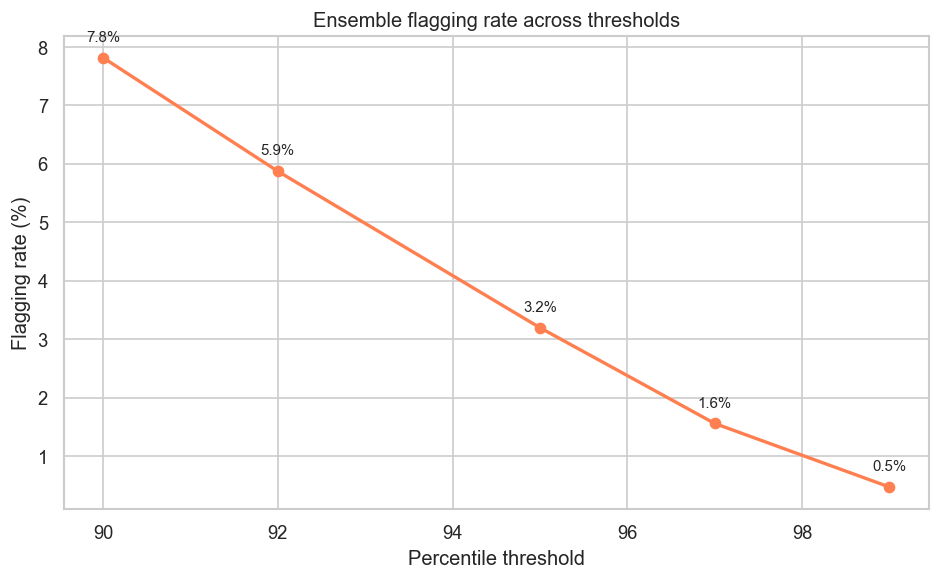

,threshold_pct,n_flagged,rate
0,0.90,3378,0.078133
1,0.92,2538,0.058704
2,0.95,1381,0.031942
3,0.97,673,0.015566
4,0.99,203,0.004695


In [14]:
# How does the flagging rate change with different percentile thresholds?
thresholds_pct = [0.90, 0.92, 0.95, 0.97, 0.99]
results = []

for pct in thresholds_pct:
    per_detector_flags = pd.DataFrame({
        col: df[col] > df[col].quantile(pct)
        for col in score_cols
    })
    n_flag = (per_detector_flags.sum(axis=1) >= 2).sum()
    results.append({"threshold_pct": pct, "n_flagged": n_flag, "rate": n_flag / len(df)})

sens = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(sens["threshold_pct"] * 100, sens["rate"] * 100, "o-", color="coral", linewidth=2)
ax.set_xlabel("Percentile threshold")
ax.set_ylabel("Flagging rate (%)")
ax.set_title("Ensemble flagging rate across thresholds")
for _, row in sens.iterrows():
    ax.annotate(f"{row['rate']*100:.1f}%", (row['threshold_pct']*100, row['rate']*100),
               textcoords="offset points", xytext=(0, 10), ha="center", fontsize=9)
plt.tight_layout()
plt.show()

sens